In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

import warnings
warnings.filterwarnings(action='ignore')

from matplotlib import font_manager, rc

In [2]:
train = pd.read_csv('dataset/data/train.csv')

In [3]:
test = pd.read_csv('dataset/data/test_date.csv')

In [4]:
test.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '년', '월', '일'],
      dtype='object')

## 식사가능자

In [56]:
test['식사가능자'] = test['본사정원수'] - test['본사휴가자수'] - test['본사출장자수'] - test['현본사소속재택근무자수']

## 요일평균 식계

In [57]:
def make_dow_avg(df_test, df_prev):
    dow_avg_ln = df_prev.groupby('요일').mean()['중식계']
    dow_avg_dn = df_prev.groupby('요일').mean()['석식계']
    
    df_test['요일평균중식계'] = 0
    tmp = dow_avg_ln.values
    for i in range(len(tmp)):
        df_test['요일평균중식계'][df_test['요일'] == i] = tmp[i]
        
    df_test['요일평균석식계'] = 0
    tmp = dow_avg_dn.values
    for i in range(len(tmp)):
        df_test['요일평균석식계'][df_test['요일'] == i] = tmp[i]
    
    return df_test

## 월평균식계

In [58]:
def make_month_avg(df_test, df_prev):
    month_avg_ln = df_prev.groupby('월').mean()['중식계']
    month_avg_dn = df_prev.groupby('월').mean()['석식계']
    
    df_test['월평균중식계'] = 0
    tmp = month_avg_ln
    tmp_k = tmp.keys(); tmp_v = tmp.values
    for i in tmp_k:
        df_test['월평균중식계'][df_test['월'] == i] = tmp_v[i-1]
        
    df_test['월평균석식계'] = 0
    tmp = month_avg_dn
    tmp_k = tmp.keys(); tmp_v = tmp.values
    for i in tmp_k:
        df_test['월평균석식계'][df_test['월'] == i] = tmp_v[i-1]
        
    return df_test

## 공휴일전후

In [59]:
test['공휴일전후'] = 0
test['공휴일전후'][10] =1
test['공휴일전후'][20] = 1

# 모델

## 점심

In [60]:
from pycaret.regression import *

In [61]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '년', '월', '일',
       '식사가능자', '전주중식계', '전주석식계', '요일평균중식계', '요일평균석식계', '월평균중식계', '월평균석식계',
       '공휴일전후'],
      dtype='object')

In [62]:
X_train_ln = train[['요일', '본사시간외근무명령서승인건수', '전주중식계', '요일평균중식계', '월평균중식계', '공휴일전후',
                '본사휴가자수', '본사출장자수', '식사가능자', '중식계']]

In [63]:
reg = setup(session_id=1,
            data=X_train_ln,
            target='중식계',
            #numeric_imputation = 'mean',
            normalize = True,
            #categorical_features=['월', '요일', '공휴일전후'],
            silent=True)

,Description,Value
0,session_id,1
1,Target,중식계
2,Original Data,"(1205, 10)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 13)"


In [64]:
top5 = compare_models(n_select=5, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,71.8420,9003.6607,94.2923,0.7917,0.1156,0.0865,0.6910
gbr,Gradient Boosting Regressor,73.1334,9304.8669,95.6047,0.7848,0.1171,0.0882,0.0250
huber,Huber Regressor,74.9167,10050.6822,99.4267,0.7677,0.1249,0.0903,0.0070
ridge,Ridge Regression,75.3434,9917.3244,98.8562,0.7711,0.1228,0.0910,0.0050
lar,Least Angle Regression,75.3711,9928.3070,98.9243,0.7708,0.1232,0.0910,0.0060
lr,Linear Regression,75.3715,9928.4604,98.9251,0.7708,0.1232,0.0910,0.3270
br,Bayesian Ridge,75.3955,9923.2800,98.8622,0.7709,0.1226,0.0911,0.0070
rf,Random Forest Regressor,75.7380,10036.3431,99.4060,0.7693,0.1235,0.0924,0.1920
lasso,Lasso Regression,75.7525,10015.2415,99.2591,0.7686,0.1228,0.0916,0.0060
lightgbm,Light Gradient Boosting Machine,75.8789,9927.7634,99.2398,0.7702,0.1234,0.0918,0.0630


In [65]:
gbr_l = tune_model(create_model('gbr', criterion='mae'), optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,86.3805,12550.9529,112.0310,0.7469,0.1418,0.1052
1,76.3429,11290.4856,106.2567,0.6730,0.1145,0.0832
2,65.1661,7970.8641,89.2797,0.8106,0.1112,0.0808
3,60.7936,6880.6362,82.9496,0.8544,0.1128,0.0815
4,58.0480,5672.4515,75.3157,0.8563,0.0875,0.0666
5,67.2914,9522.2819,97.5822,0.7893,0.1259,0.0831
6,80.3090,11922.0444,109.1881,0.7313,0.1258,0.0931
7,68.5080,6832.9709,82.6618,0.7915,0.0970,0.0789
8,73.4903,9136.4033,95.5845,0.8123,0.1085,0.0857
9,71.5605,9624.0493,98.1022,0.8221,0.1393,0.0947


In [66]:
pred_holdouts = predict_model(gbr_l)
final_model_l = finalize_model(gbr_l)
final_model_l

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,67.5220,8337.7513,91.3113,0.8071,0.1157,0.0845


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.05, loss='ls', max_depth=4,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.05, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=260,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

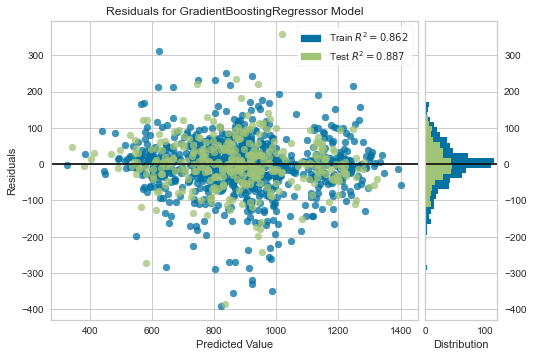

In [34]:
plot_model(final_model_l)

## 저녁

In [137]:
train = pd.read_csv('dataset/data/train_dinner.csv')

In [138]:
X_train_dn = train[['요일', '본사시간외근무명령서승인건수', '전주석식계', '요일평균석식계', '월평균석식계', '공휴일전후',
                '본사휴가자수', '본사출장자수', '식사가능자', '석식계']]

In [140]:
reg = setup(session_id=2,
            data=X_train_dn,
            target='석식계',
            #numeric_imputation = 'mean',
            normalize = True,
            #categorical_features=['월', '요일', '공휴일전후'],
            silent=True)

,Description,Value
0,session_id,2
1,Target,석식계
2,Original Data,"(1162, 10)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(813, 13)"


In [141]:
top5 = compare_models(n_select=5, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,48.4999,4127.9035,64.0610,0.6400,0.1595,0.1176,0.6890
gbr,Gradient Boosting Regressor,50.8189,4431.0407,66.4500,0.6122,0.1640,0.1229,0.0240
lightgbm,Light Gradient Boosting Machine,51.1701,4500.3569,66.8673,0.6075,0.1659,0.1243,0.0600
rf,Random Forest Regressor,51.1911,4615.2600,67.7211,0.5962,0.1688,0.1246,0.1860
et,Extra Trees Regressor,51.3763,4730.1317,68.6103,0.5858,0.1711,0.1245,0.1730
xgboost,Extreme Gradient Boosting,52.9100,4909.7447,69.9396,0.5722,0.1711,0.1264,0.1920
huber,Huber Regressor,55.5365,5372.0798,73.0996,0.5282,0.1815,0.1365,0.0060
lr,Linear Regression,55.6884,5304.2109,72.6820,0.5345,0.1801,0.1360,0.3280
ridge,Ridge Regression,55.6916,5302.6140,72.6735,0.5347,0.1802,0.1361,0.0060
br,Bayesian Ridge,55.7423,5311.0813,72.7390,0.5343,0.1810,0.1367,0.0050


In [142]:
blended_d = blend_models(top5, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,44.5541,4017.4790,63.3836,0.6204,0.1894,0.1232
1,50.1192,4805.9243,69.3248,0.5726,0.1948,0.1312
2,50.9872,4212.3678,64.9028,0.6830,0.1492,0.1161
3,46.7281,3532.3710,59.4338,0.6163,0.1314,0.1033
4,50.0215,4006.0920,63.2937,0.7454,0.1788,0.1290
5,45.1677,3126.8766,55.9185,0.7119,0.1275,0.1003
6,45.3566,3601.7274,60.0144,0.6930,0.1354,0.1032
7,50.7546,5121.1057,71.5619,0.5094,0.1533,0.1152
8,50.9897,4806.7904,69.3310,0.6239,0.1845,0.1352
9,53.0736,4527.0918,67.2837,0.5742,0.1597,0.1291


In [119]:
et_d = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,44.1786,3710.2311,60.9117,0.6494,0.1804,0.1198
1,52.8970,5212.2419,72.1959,0.5365,0.1996,0.1368
2,46.9871,3722.9106,61.0157,0.7199,0.1315,0.1030
3,46.5063,3743.9491,61.1878,0.5933,0.1355,0.1035
4,53.0867,4460.5020,66.7870,0.7165,0.1813,0.1340
5,50.6457,3744.1129,61.1892,0.6550,0.1467,0.1163
6,47.0551,4096.7243,64.0057,0.6509,0.1448,0.1077
7,51.0058,5273.9797,72.6222,0.4947,0.1561,0.1151
8,47.4133,4248.1565,65.1779,0.6676,0.1760,0.1261
9,52.5730,4598.2370,67.8103,0.5675,0.1597,0.1288


In [156]:
pred_holdouts = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
final_model_d

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,49.8420,4631.0156,68.0516,0.6121,0.1532,0.1150


VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x000002047705CA48>),
                            ('gbr',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_sa

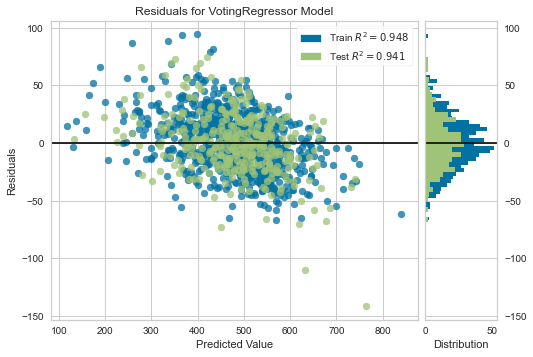

In [157]:
plot_model(final_model_d)

# 추론

## Test 5일마다 split

In [67]:
submission_df = pd.read_csv('./../data/sample_submission.csv')

In [146]:
res = []
X_test = test[['요일', '본사시간외근무명령서승인건수', '공휴일전후', '월', '일자', '일', '년',
                '본사휴가자수', '본사출장자수', '식사가능자']][:5]

In [147]:
X_test

,요일,본사시간외근무명령서승인건수,공휴일전후,월,일자,일,년,본사휴가자수,본사출장자수,식사가능자
0,2,5,0,1,2021-01-27,27,2021,88,182,2355.0
1,1,409,0,1,2021-01-28,28,2021,104,212,2319.0
2,0,0,0,1,2021-01-29,29,2021,270,249,2170.0
3,3,538,0,2,2021-02-01,1,2021,108,154,2340.0
4,4,455,0,2,2021-02-02,2,2021,62,186,2362.0


In [148]:
X_train_ln.columns

Index(['요일', '본사시간외근무명령서승인건수', '전주중식계', '요일평균중식계', '월평균중식계', '공휴일전후', '본사휴가자수',
       '본사출장자수', '식사가능자', '중식계'],
      dtype='object')

In [149]:
from datetime import timedelta
X_test = make_dow_avg(X_test, train)
X_test = make_month_avg(X_test, train)
X_test['전주중식계'] = 0
X_test['전주석식계'] = 0
index = pd.DatetimeIndex(X_test['일자']) + timedelta(weeks=-1)
for i in range(5):
    X_test['전주중식계'][i] = train[train['일자'] == str(index[i])[:10]]['중식계']
    X_test['전주석식계'][i] = train[train['일자'] == str(index[i])[:10]]['석식계']

In [150]:
X_test.columns

Index(['요일', '본사시간외근무명령서승인건수', '공휴일전후', '월', '일자', '일', '년', '본사휴가자수',
       '본사출장자수', '식사가능자', '요일평균중식계', '요일평균석식계', '월평균중식계', '월평균석식계', '전주중식계',
       '전주석식계'],
      dtype='object')

In [ ]:
pred_ln = predict_model(final_model_l, X_test[['요일', '본사시간외근무명령서승인건수', '전주중식계', '요일평균중식계', '월평균중식계', '공휴일전후','본사휴가자수', '본사출장자수', '식사가능자']])

In [74]:
submission_df['중식계'][:5] = pred_ln['Label']

In [151]:
pred_dn = predict_model(final_model_d, X_test[['요일', '본사시간외근무명령서승인건수', '전주석식계', '요일평균석식계', '월평균석식계', '공휴일전후','본사휴가자수', '본사출장자수', '식사가능자']])

In [152]:
submission_df['석식계'][:5] = pred_dn['Label']

In [155]:
submission_df

,일자,중식계,석식계
0,2021-01-27,980.654934,437.405144
1,2021-01-28,931.951907,447.897298
2,2021-01-29,622.249575,255.183032
3,2021-02-01,1209.063556,625.558443
4,2021-02-02,1047.370794,580.495172
5,2021-02-03,0.000000,0.000000
6,2021-02-04,0.000000,0.000000
7,2021-02-05,0.000000,0.000000
8,2021-02-08,0.000000,0.000000
9,2021-02-09,0.000000,0.000000


In [154]:
submission_df.to_csv('submission/dinner_change.csv', index=False)

In [ ]:

train['전주중식계'] = 0
train['전주석식계'] = 0
idx = pd.DatetimeIndex(train['일자']) + timedelta(weeks=-1)
for i in range(len(train)):
    try:
        train['전주중식계'][i] = train[train['일자'] == str(idx[i])[:10]]['중식계']
        train['전주석식계'][i] = train[train['일자'] == str(idx[i])[:10]]['석식계']
    except:
        train['전주중식계'][i] = train.iloc[i,:]['중식계']
        train['전주석식계'][i] = train.iloc[i,:]['석식계']

train[['중식계', '전주중식계', '석식계', '전주석식계', '일자']].head(10)